# Regrid NorESM data to DGGS

### Description

1. Load required libraries
2. Load example data with sea surface temperature
3. Calculate latitude and longitude 
4. Plot on original grid
5. Define new DGGS target grid
6. Regrid to DGGS
7. Plot in the DGGS coordinates

## Contributions
- Even Moa Myklebust, Simula Research Laboratory (Norway) (author), @evenmm
- Yanchun He, NERSC (Norway) (provider of data and tutorial functions for loading data), @YanchunHe

## Bibliography and other interesting resources
- [The Norwegian Earth System Model (NorESM)](https://noresm-docs.readthedocs.io/en/latest/)


## 1. Load required libraries

In [1]:
# Install xarray-healpy and dggs libraries for regridding
%pip install git+https://github.com/IAOCEA/xarray-healpy.git git+https://github.com/xarray-contrib/xdggs.git cmcrameri

  Cloning https://github.com/IAOCEA/xarray-healpy.git to /private/var/folders/_r/k7zwg4td0z54sgjlxsfx325m0000gn/T/pip-req-build-e56rp_9c
  Running command git clone --filter=blob:none --quiet https://github.com/IAOCEA/xarray-healpy.git /private/var/folders/_r/k7zwg4td0z54sgjlxsfx325m0000gn/T/pip-req-build-e56rp_9c
  Resolved https://github.com/IAOCEA/xarray-healpy.git to commit 5bc2b3a26537dbe8af850110223ceaf1c15b54d2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/xarray-contrib/xdggs.git to /private/var/folders/_r/k7zwg4td0z54sgjlxsfx325m0000gn/T/pip-req-build-zl9e8gcq
  Running command git clone --filter=blob:none --quiet https://github.com/xarray-contrib/xdggs.git /private/var/folders/_r/k7zwg4td0z54sgjlxsfx325m0000gn/T/pip-req-build-zl9e8gcq
  Resolved https://github.com/xarray-contrib/xdggs.git to commit 34d8769843d91dd4b452e7d0c52b968e5fd3a2ca
  Installing build de

In [2]:
import os
from pathlib import Path
import numpy as np
import s3fs                                                # For accessing file storage at Amazon S3
import xdggs                                               # Discrete global grid systems in x-array
import xarray as xr                                        # N-dimensional arrays with dimension, coordinate and attribute labels
from xarray_healpy import HealpyGridInfo, HealpyRegridder
xr.set_options(display_expand_data=False, display_expand_attrs=False, keep_attrs=True)

In [3]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib as mpl
#matplotlib.use('pgf')

In [4]:
# Local imports
from data_handling import load_grid_vertex, center_longitude

## 2. Load example data with sea surface temperature
Data contains temperature at a single time point.  
This grid (nearside perspective) is irregular.  
We can use x and y as indices.  
If we need lat and lon values, they must be calculated for each grid cell separately.  

In [5]:
data_path = Path('./CS1-nird/')
subset_dataset_path = data_path / 'data' / 'model' / 'JRAOC20TRNRPv2_hm_sst_2010-01.nc'
ds = xr.open_dataset(subset_dataset_path)
ds

<xarray.Dataset> Size: 554kB
Dimensions:  (time: 1, y: 385, x: 360)
Coordinates:
  * time     (time) object 8B 2010-01-17 00:00:00
Dimensions without coordinates: y, x
Data variables:
    sst      (time, y, x) float32 554kB ...

In [6]:
print(ds.dims)

FrozenMappingWarningOnValuesAccess({'time': 1, 'y': 385, 'x': 360})


## 3. Calculate latitude and longitude

In [7]:
# Get grid location information
grid_path = data_path / 'data' / 'grid' / 'grid.nc'
plat, plon, pclat, pclon = load_grid_vertex(grid_path)

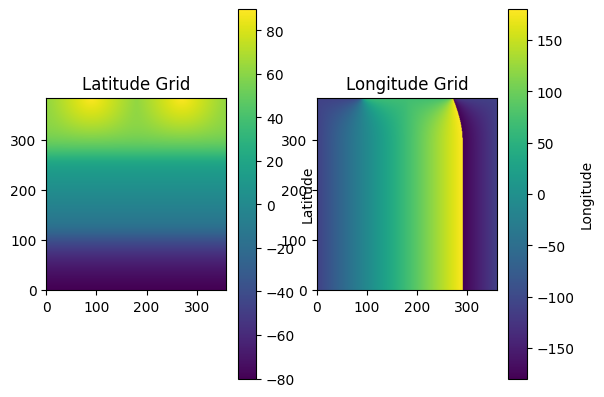

In [8]:
# Plot plat and plon to visualize the grid

plt.subplot(1, 2, 1)
plt.imshow(plat, origin="lower")
plt.colorbar(label="Latitude")
plt.title("Latitude Grid")

plt.subplot(1, 2, 2)
plt.imshow(plon, origin="lower")
plt.colorbar(label="Longitude")
plt.title("Longitude Grid")

plt.show()

In [9]:
# Irregular/curvilinear grid 
ds = ds.assign_coords(lat=(["y", "x"], plat), lon=(["y", "x"], plon))
ds

<xarray.Dataset> Size: 3MB
Dimensions:  (time: 1, y: 385, x: 360)
Coordinates:
  * time     (time) object 8B 2010-01-17 00:00:00
    lat      (y, x) float64 1MB -80.11 -80.11 -80.11 ... 62.59 62.35 62.11
    lon      (y, x) float64 1MB -109.5 -108.5 -107.5 ... -109.9 -109.9 -110.0
Dimensions without coordinates: y, x
Data variables:
    sst      (time, y, x) float32 554kB ...

In [10]:
print(ds)

<xarray.Dataset> Size: 3MB
Dimensions:  (time: 1, y: 385, x: 360)
Coordinates:
  * time     (time) object 8B 2010-01-17 00:00:00
    lat      (y, x) float64 1MB -80.11 -80.11 -80.11 ... 62.59 62.35 62.11
    lon      (y, x) float64 1MB -109.5 -108.5 -107.5 ... -109.9 -109.9 -110.0
Dimensions without coordinates: y, x
Data variables:
    sst      (time, y, x) float32 554kB ...


In [11]:
print(np.max(plat), np.min(plat), np.max(plon), np.min(plon))

89.75749503829726 -80.11491140591812 179.9889159673213 -179.9967955192592


In [12]:
#ds = ds.rename_dims({"lat": "latitude", "lon": "longitude"})
#ds = ds.rename_vars({"lat": "latitude", "lon": "longitude"})
#ds.latitude.attrs["standard_name"] = 'latitude'
#ds.longitude.attrs["standard_name"] = 'longitude'
ds = ds.rename_vars({"lat": "latitude", "lon": "longitude"})
ds.latitude.attrs["standard_name"] = "latitude"
ds.longitude.attrs["standard_name"] = "longitude"

In [13]:
# The data is centered around 0 longitude, so no centering is necessary.

#ds.coords['longitude'] = (ds.coords['longitude'] + 180) % 360 - 180
#ds = ds.sortby(ds.longitude)

## 4. Plot on original grid

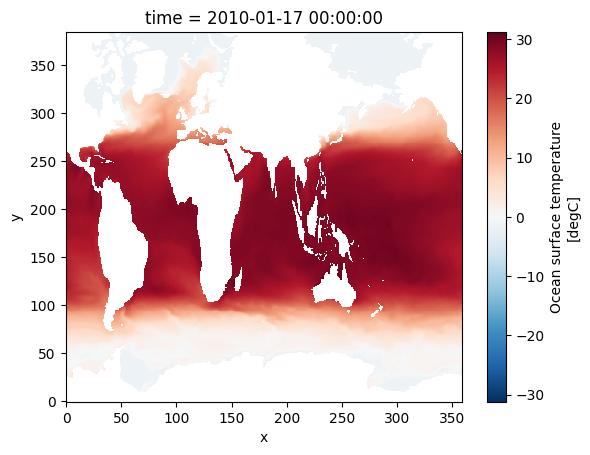

In [14]:
# Plot reference height temperature (TREFHT)
ds.sst.isel(time=0).plot()

When we plot using x and y, it looks like the North pole is missing, but this is just due to the projection.  
In reality, the North edges of Russia and Canada are "glued together" when plotting in a better projection.

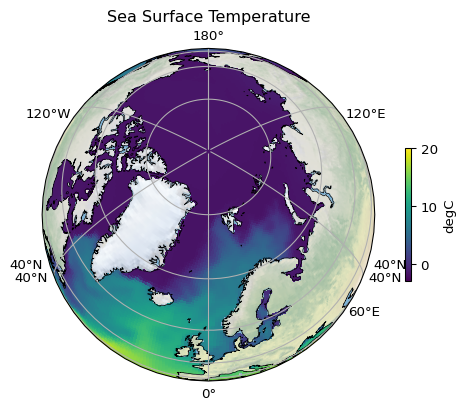

In [15]:
proj = ccrs.NearsidePerspective(central_longitude=0.0, central_latitude=80.0, satellite_height=3e6)
fig, ax = plt.subplots(1, figsize=(8, 4.5),dpi=96,subplot_kw={"projection": proj})

# A temperature map
pm0 = ax.pcolormesh(plon, plat, ds.sst[0,:,:],
                   vmin=-3,vmax=20,
                   cmap='viridis',
                   transform=ccrs.PlateCarree(),
                   shading='auto',
                   rasterized=True)


# Add coastlines and the lat-lon grid
ax.coastlines(resolution='50m', color='black', linewidth=0.5)
ax.stock_img()
gl = ax.gridlines(ylocs=range(15,76,15), draw_labels=True)
gl.ylocator = mpl.ticker.FixedLocator([40, 50, 60, 70, 80])

plt.colorbar(pm0, fraction=0.2, shrink=0.4, label='degC')

ax.set_title('Sea Surface Temperature')
plt.show()

#plt.savefig('../figures/sst.pdf')

## 5. Define target grid: DGGS

In [16]:
nside = 16                               # Each side of the original 12 faces in Healpix is divided into nside parts 
healpy_grid_level = int(np.log2(nside))  # Healpix level
number_of_cells = 12*nside**2            # The resulting total number of cells

print("nside:", nside)
print("Level:", healpy_grid_level)
print("Number of cells:", number_of_cells)

nside: 16
Level: 4
Number of cells: 3072


In [17]:
# Define the target Healpix grid
grid = HealpyGridInfo(level=healpy_grid_level)
target_grid = grid.target_grid(ds).pipe(center_longitude, 0).drop_attrs(deep=False).dggs.decode({"grid_name": "healpix", "nside": nside, "indexing_scheme": "nested"})

In [18]:
%%time
# Compute interpolation weights for regridding data
regridder = HealpyRegridder(
    ds[["longitude", "latitude"]].compute(),
    target_grid,
    method="bilinear",
    interpolation_kwargs={},
)
print(regridder)

ZeroDivisionError: division by zero

In [19]:
import xesmf as xe

# Define the source grid (curvilinear)
ds_grid = xr.Dataset({"lat": (["y", "x"], plat), "lon": (["y", "x"], plon)})

# Define the target DGGS grid (replace with your DGGS lat/lon centers)
dggs_lat, dggs_lon = get_dggs_latlon()  # Placeholder for DGGS cell centers
ds_dggs = xr.Dataset({"lat": (["dggs"], dggs_lat), "lon": (["dggs"], dggs_lon)})

# Create the regridder (bilinear method)
regridder = xe.Regridder(ds_grid, ds_dggs, "bilinear")

# Apply regridding
ds_sst_dggs = regridder(ds.sst)

print(ds_sst_dggs)


ModuleNotFoundError: No module named 'ESMF'

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.pcolormesh(plon, plat, ds.sst[0, :, :], shading='auto')
plt.colorbar(label="SST (Original)")
plt.title("Original Curvilinear Grid")

plt.subplot(1, 2, 2)
plt.scatter(dggs_lon, dggs_lat, c=sst_dggs, s=10, cmap="viridis")
plt.colorbar(label="SST (Regridded to DGGS)")
plt.title("Regridded to DGGS")

plt.show()


In [ ]:
# The following has not been tested yet

## 6. Regrid to DGGS

In [ ]:
import xesmf as xe

# Define the source grid (curvilinear)
ds_grid = xr.Dataset({"lat": (["y", "x"], plat), "lon": (["y", "x"], plon)})

# Define the target DGGS grid (replace with your DGGS lat/lon centers)
dggs_lat, dggs_lon = get_dggs_latlon()  # Placeholder for DGGS cell centers
ds_dggs = xr.Dataset({"lat": (["dggs"], dggs_lat), "lon": (["dggs"], dggs_lon)})

# Create the regridder (bilinear method)
regridder = xe.Regridder(ds_grid, ds_dggs, "bilinear")

# Apply regridding
ds_sst_dggs = regridder(ds.sst)

print(ds_sst_dggs)


In [ ]:
print(ds.coords)

In [ ]:
# Sort the latitude and longitude values (https://github.com/pydata/xarray/issues/967)
ds = ds.reindex(indexers={'lat':sorted(ds.coords['lat'].values), 'lon':sorted(ds.coords['lon'].values)})
ds

## 7. Plot in the DGGS coordinates

In [ ]:
proj = ccrs.NearsidePerspective(central_longitude=0.0, central_latitude=80.0, satellite_height=3e6)
fig, ax = plt.subplots(1, figsize=(8, 4.5),dpi=96,subplot_kw={"projection": proj})

# A temperature map
pm0 = ax.pcolormesh(plon, plat, ds.sst[:,:],
                   vmin=-3,vmax=20,
                   cmap='viridis',
                   transform=ccrs.PlateCarree(),
                   shading='auto',
                   rasterized=True)


# Add coastlines and the lat-lon grid
ax.coastlines(resolution='50m', color='black', linewidth=0.5)
ax.stock_img()
gl = ax.gridlines(ylocs=range(15,76,15), draw_labels=True)
gl.ylocator = mpl.ticker.FixedLocator([40, 50, 60, 70, 80])

plt.colorbar(pm0, fraction=0.2, shrink=0.4, label='degC')

ax.set_title('Sea Surface Temperature')
plt.show()

#plt.savefig('../figures/sst.pdf')

In [ ]:
# Plot reference height temperature (TREFHT) in latitude and longitude coordinates
ds.sst.isel(time=0).plot()